In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

# Deep Agent for Research

## Overview 

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

Now, we can put everything we have learned together:

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

## Search Tool 

We'll build a search tool that offloads raw contents to files and returns only a summary to the agent. This is a common pattern for long-running agent trajectories, [as we've seen with Manus](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus)! 

### Core Components

1. **Search Execution (`run_tavily_search`)**: Performs the actual web search using Tavily API with configurable parameters for results count and topic filtering.

2. **Content Summarization (`summarize_webpage_content`)**: Uses a lightweight model (GPT-4o-mini) to generate structured summaries of webpage content, producing both a descriptive filename and key learnings summary.

3. **Result Processing (`process_search_results`)**: Fetches full webpage content via HTTP, converts HTML to markdown using `markdownify`, and generates summaries for each result.

4. **Context Offloading (`tavily_search` tool)**: The main tool that:
   - Executes search and processes results
   - Saves full content to files in agent state (context offloading)
   - Returns only minimal summaries to the agent (prevents context spam)
   - Uses LangGraph `Command` to update both files and messages

5. **Strategic Thinking (`think_tool`)**: Provides a structured reflection mechanism for agents to analyze findings, assess gaps, and plan next steps in their research workflow.

This architecture solves the token efficiency problem by storing detailed search results in files while keeping the agent's working context minimal and focused.

In [2]:
%%writefile ../src/deep_agents_from_scratch/research_tools.py
"""Research Tools.

This module provides search and content processing utilities for the research agent,
including web search capabilities and content summarization tools.
"""
import os
from datetime import datetime
import uuid, base64

import httpx
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.tools import InjectedToolArg, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from markdownify import markdownify
from pydantic import BaseModel, Field
from tavily import TavilyClient
from typing_extensions import Annotated, Literal

from deep_agents_from_scratch.prompts import SUMMARIZE_WEB_SEARCH
from deep_agents_from_scratch.state import DeepAgentState

# Summarization model 
summarization_model = init_chat_model(model="openai:gpt-4o-mini")
tavily_client = TavilyClient()

class Summary(BaseModel):
    """Schema for webpage content summarization."""
    filename: str = Field(description="Name of the file to store.")
    summary: str = Field(description="Key learnings from the webpage.")

def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %-d, %Y")

def run_tavily_search(
    search_query: str, 
    max_results: int = 1, 
    topic: Literal["general", "news", "finance"] = "general", 
    include_raw_content: bool = True, 
) -> dict:
    """Perform search using Tavily API for a single query.

    Args:
        search_query: Search query to execute
        max_results: Maximum number of results per query
        topic: Topic filter for search results
        include_raw_content: Whether to include raw webpage content

    Returns:
        Search results dictionary
    """
    result = tavily_client.search(
        search_query,
        max_results=max_results,
        include_raw_content=include_raw_content,
        topic=topic
    )

    return result

def summarize_webpage_content(webpage_content: str) -> Summary:
    """Summarize webpage content using the configured summarization model.
    
    Args:
        webpage_content: Raw webpage content to summarize
        
    Returns:
        Summary object with filename and summary
    """
    try:
        # Set up structured output model for summarization
        structured_model = summarization_model.with_structured_output(Summary)
        
        # Generate summary
        summary_and_filename = structured_model.invoke([
            HumanMessage(content=SUMMARIZE_WEB_SEARCH.format(
                webpage_content=webpage_content, 
                date=get_today_str()
            ))
        ])
        
        return summary_and_filename
        
    except Exception:
        # Return a basic summary object on failure
        return Summary(
            filename="search_result.md",
            summary=webpage_content[:1000] + "..." if len(webpage_content) > 1000 else webpage_content
        )

def process_search_results(results: dict) -> list[dict]:
    """Process search results by summarizing content where available.
    
    Args:
        results: Tavily search results dictionary
        
    Returns:
        List of processed results with summaries
    """
    processed_results = []

    # Create a client for HTTP requests
    HTTPX_CLIENT = httpx.Client()
    
    for result in results.get('results', []):
        
        # Get url 
        url = result['url']
        
        # Read url
        response = HTTPX_CLIENT.get(url)

        if response.status_code == 200:
            # Convert HTML to markdown
            raw_content = markdownify(response.text)
            summary_obj = summarize_webpage_content(raw_content)
        else:
            # Use Tavily's generated summary
            raw_content = result.get('raw_content', '')
            summary_obj = Summary(
                filename="URL_error.md",
                summary=result.get('content', 'Error reading URL; try another search.')
            )
        
        # uniquify file names
        uid = base64.urlsafe_b64encode(uuid.uuid4().bytes).rstrip(b"=").decode("ascii")[:8]
        name, ext = os.path.splitext(summary_obj.filename)
        summary_obj.filename = f"{name}_{uid}{ext}"

        processed_results.append({
            'url': result['url'],
            'title': result['title'],
            'summary': summary_obj.summary,
            'filename': summary_obj.filename,
            'raw_content': raw_content,
        })
    
    return processed_results

@tool(parse_docstring=True)
def tavily_search(
    query: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
    max_results: Annotated[int, InjectedToolArg] = 1,
    topic: Annotated[Literal["general", "news", "finance"], InjectedToolArg] = "general",
) -> Command:
    """Search web and save detailed results to files while returning minimal context.

    Performs web search and saves full content to files for context offloading.
    Returns only essential information to help the agent decide on next steps.

    Args:
        query: Search query to execute
        state: Injected agent state for file storage
        tool_call_id: Injected tool call identifier
        max_results: Maximum number of results to return (default: 1)
        topic: Topic filter - 'general', 'news', or 'finance' (default: 'general')

    Returns:
        Command that saves full results to files and provides minimal summary
    """
    # Execute search
    search_results = run_tavily_search(
        query,
        max_results=max_results,
        topic=topic,
        include_raw_content=True,
    ) 

    # Process and summarize results
    processed_results = process_search_results(search_results)
    
    # Save each result to a file and prepare summary
    files = state.get("files", {})
    saved_files = []
    summaries = []
    
    for i, result in enumerate(processed_results):
        # Use the AI-generated filename from summarization
        filename = result['filename']
        
        # Create file content with full details
        file_content = f"""# Search Result: {result['title']}

**URL:** {result['url']}
**Query:** {query}
**Date:** {get_today_str()}

## Summary
{result['summary']}

## Raw Content
{result['raw_content'] if result['raw_content'] else 'No raw content available'}
"""
        
        files[filename] = file_content
        saved_files.append(filename)
        summaries.append(f"- {filename}: {result['summary']}...")
    
    # Create minimal summary for tool message - focus on what was collected
    summary_text = f"""🔍 Found {len(processed_results)} result(s) for '{query}':

{chr(10).join(summaries)}

Files: {', '.join(saved_files)}
💡 Use read_file() to access full details when needed."""

    return Command(
        update={
            "files": files,
            "messages": [
                ToolMessage(summary_text, tool_call_id=tool_call_id)
            ],
        }
    )

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.

    Use this tool after each search to analyze results and plan next steps systematically.
    This creates a deliberate pause in the research workflow for quality decision-making.

    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    - Before concluding research: Can I provide a complete answer now?
    - How complex is the question: Have I reached the number of search limits?

    Reflection should address:
    1. Analysis of current findings - What concrete information have I gathered?
    2. Gap assessment - What crucial information is still missing?
    3. Quality evaluation - Do I have sufficient evidence/examples for a good answer?
    4. Strategic decision - Should I continue searching or provide my answer?

    Args:
        reflection: Your detailed reflection on research progress, findings, gaps, and next steps

    Returns:
        Confirmation that reflection was recorded for decision-making
    """
    return f"Reflection recorded: {reflection}"

Overwriting ../src/deep_agents_from_scratch/research_tools.py


## Deep Agent

Now, we can just apply all of our prior learnings: 

* We'll give the researcher a `think_tool` and our `search_tool` above.
* We'll give our parent agent file tools, a `think_tool`, and a `task` tool. 

In [3]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
#from langgraph.prebuilt import create_react_agent
from langchain.agents import create_agent
from utils import show_prompt, stream_agent

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool, get_today_str
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tools import write_todos, read_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Tools
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, read_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": ["tavily_search", "think_tool"],
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

delegation_tools = [task_tool]
all_tools = sub_agent_tools + built_in_tools + delegation_tools  # search available to main agent for trivial cases

# Build prompt
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
    max_concurrent_research_units=max_concurrent_research_units,
    max_researcher_iterations=max_researcher_iterations,
    date=datetime.now().strftime("%a %b %-d, %Y"),
)

In [4]:
show_prompt(RESEARCHER_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You are a research assistant conducting research on the user's input topic. For context, today's date is       │
│  {date}.                                                                                                        │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your job is to use tools to gather information about the user's input topic.                                   │
│  You can use any of the tools provided to you to find resources that can help answer the research question.     │
│  You can call these tools in series or in parallel, your research is conducted in a tool-calling loop.          │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  You have access to two main tools:                                                                             │
│  1. **tavily_search**: For conducting web searches to gather information                                        │
│  2. **think_tool**: For reflection and strategic planning during research                                       │
│                                                                                                                 │
│  **CRITICAL: Use think_tool after each search to reflect on results and plan next steps**                       │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  Think like a human researcher with limited time. Follow these steps:                                           │
│                                                                                                                 │
│  1. **Read the question carefully** - What specific information does the user need?                             │
│  2. **Start with broader searches** - Use broad, comprehensive queries first                                    │
│  3. **After each search, pause and assess** - Do I have enough to answer? What's still missing?                 │
│  4. **Execute narrower searches as you gather information** - Fill in the gaps                                  │
│  5. **Stop when you can answer confidently** - Don't keep searching for perfection                              │
│  </Instructions>                                                                                                │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Tool Call Budgets** (Prevent excessive searching):                                                           │
│  - **Simple queries**: Use 1-2 search tool calls maximum                                                        │
│  - **Normal queries**: Use 2-3 search tool calls maximum                                                        │
│  - **Very Complex queries**: Use up to 5 search tool calls maximum                                              │
│  - **Always stop**: After 5 search tool calls if you c

In [5]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n"
    + TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# FILE SYSTEM USAGE\n"
    + FILE_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + "# SUB-AGENT DELEGATION\n"
    + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                               

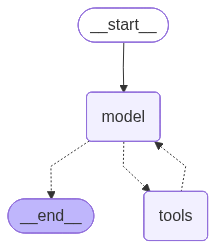

In [6]:
# Create agent
agent = create_agent(  #updated 1.0
    model, all_tools, system_prompt=INSTRUCTIONS, state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

/Users/geoffladwig/Documents/Github/TestV1/deep-agents-from-scratch/.venv/lib/python3.13/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then delegate the research task.                                                                       │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01HHCesad27etqNffHnK91tC                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'pending'},       │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'pending'}, {'content': 'Compile comprehensive overview based on research │
│ findings', 'status': 'pending'}]                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01AMrNADEQyRwxEEU5jJEF32                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Objective\nProvide a comprehensive overview covering:\n- Definition and purpose of MCP\n- Key features and      │
│ capabilities\n- Architecture and technical details\n- Use cases and applications\n- Current development         │
│ status\n- Relationship to other protocols/standards"                                                            │
│ }                                                                                                               │
│    ID: toolu_01QUQH2vZpGgkQMpeyiR6yrr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01FnzpYzrL83DaEcahc6GMZc                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ⏳ Save user request to file system for reference (pending)                                                  │
│ 2. ⏳ Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use cases, and   │
│ current status (pending)                                                                                        │
│ 3. ⏳ Compile comprehensive overview based on research findings (pending)                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_015BL42xqtLTkb2LRa27NDi3                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'in_progress'}, {'content': 'Compile comprehensive overview based on      │
│ research findings', 'status': 'pending'}]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now I'll delegate the research task to a specialized research agent to gather comprehensive information about   │
│ Model Context Protocol.                                                                                         │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need detailed information covering:  │
│ 1) What MCP is and its core purpose/goals, 2) Key technical features and capabilities, 3) Architecture and how  │
│ it works, 4) Primary use cases and applications, 5) Current development status and adoption, 6) Who developed   │
│ it and when, 7) How it relates to other protocols or standards in the AI/ML space. Focus on official sources,   │
│ documentation, and recent developments.",                                                                       │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Y72usBLDe76jz7QKnawvuq                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's detailed information about the Model Context Protocol (MCP) covering │
│ all the aspects you requested:                                                                                  │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Core Purpose/Goals                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an **open standard developed by Anthropic** designed to improve             │
│ interactions between Large Language Models (LLMs) and applications through structured context management. Its   │
│ core purpose is to provide a **unified interface** that allows AI systems to connect with external tools and    │
│ databases seamlessly.                                                                                           │
│                                                                                                                 │
│ **Key Goals:**                                                                                                  │
│ - **Standardization**: Eliminate the need for custom integrations between AI models and external systems        │
│ - **Interoperability**: Enable smooth communication between different AI applications and external data sources │
│ - **Efficiency**: Streamline the development process for AI applications                                        │
│ - **Real-time Access**: Provide up-to-date information access, significantly improving the reliability and      │
│ contextual relevance of AI responses                                                                            │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ **Core Technical Features:**                                                                                    │
│ - **JSON-RPC 2.0 Protocol**: Uses JSON-RPC 2.0 for structured client-server interactions                        │
│ - **Modular Architecture**: Flexible implementation allowing applications to implement only required components │
│ - **Authorization Framework**: Built-in security mechanisms for secure interactions                             │
│ - **Lifecycle Management**: Comprehensive management of connection states and message flows                     │
│ - **Core Message Types**: Standardized message formats for consistent communication                             │
│ - **Transport Mechanisms**: Multiple transport options for different deployment scenarios                       │
│ - **Sampling Capabilities**: Advanced context sampling and management features                                  │
│                                                                                                                 │
│ ## 3. Architecture and How It Works                                                                             │
│                                                                                                                 │
│ MCP operates on a **client-server architecture** with the following key components:                             │
│                                                                                                                 │
│ **Architecture Overview:**                                                                                      │
│ - **Client-Server Model**: AI applications (clients) co

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent has provided comprehensive information about Model Context Protocol (MCP).  │
│ The findings cover all the key aspects I requested:\n\n1. ✅ Definition and purpose - MCP is an open standard   │
│ by Anthropic for standardized AI-external system communication\n2. ✅ Technical features - JSON-RPC 2.0,        │
│ modular architecture, authorization framework\n3. ✅ Architecture - Client-server model with structured context │
│ management\n4. ✅ Use cases - Database integration, tool integration, API connectivity, enterprise              │
│ integration\n5. ✅ Development status - Very recent (2024-2025), actively developed, growing adoption\n6. ✅    │
│ Developer info - Created by Anthropic\n7. ✅ Relationship to other protocols - Complementary to LangChain,      │
│ operates at protocol layer\n\nThe information appears comprehensive and well-structured. The research indicates │
│ MCP is a very recent but significant development in AI infrastructure. I have sufficient information to provide │
│ a complete overview to the user. I should now compile this into a clear, organized response."                   │
│ }                                                                                                               │
│    ID: toolu_017eZAVCw3r5XEHY1mL3WXxk                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent has provided comprehensive information about Model Context Protocol     │
│ (MCP). The findings cover all the key aspects I requested:                                                      │
│                                                                                                                 │
│ 1. ✅ Definition and purpose - MCP is an open standard by Anthropic for standardized AI-external system         │
│ communication                                                                                                   │
│ 2. ✅ Technical features - JSON-RPC 2.0, modular architecture, authorization framework                          │
│ 3. ✅ Architecture - Client-server model with structured context management                                     │
│ 4. ✅ Use cases - Database integration, tool integration, API connectivity, enterprise integration              │
│ 5. ✅ Development status - Very recent (2024-2025), actively developed, growing adoption                        │
│ 6. ✅ Developer info - Created by Anthropic                                                                     │
│ 7. ✅ Relationship to other protocols - Complementary to LangChain, operates at protocol layer                  │
│                                                                                                                 │
│ The information appears comprehensive and well-structured. The research indicates MCP is a very recent but      │
│ significant development in AI infrastructure. I have sufficient information to provide a complete overview to   │
│ the user. I should now compile this into a clear, organized response.                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01Ru7FsHPBNAAzuHzSfE7Qs9                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. ✅ Save user request to file system for reference (completed)                                                │
│ 2. 🔄 Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use cases, and   │
│ current status (in_progress)                                                                                    │
│ 3. ⏳ Compile comprehensive overview based on research findings (pending)                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Save user request to file system for reference",                                              │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use  │
│ cases, and current status",                                                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Compile comprehensive overview based on research findings",                                   │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01YANfQAiRAK1hYHpiqPHkDa                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview based on        │
│ research findings', 'status': 'in_progress'}]                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) - Comprehensive Overview                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an **open standard developed by Anthropic** that provides a unified         │
│ interface for Large Language Models (LLMs) to connect with external tools and databases. Think of it as a       │
│ standardized "language" that allows AI systems to communicate seamlessly with external resources, eliminating   │
│ the need for custom integrations.                                                                               │
│                                                                                                                 │
│ ## Core Purpose & Goals                                                                                         │
│                                                                                                                 │
│ MCP addresses a critical challenge in AI development: **how to efficiently connect AI models to external        │
│ systems**. Its main objectives are:                                                                             │
│                                                                                                                 │
│ - **🔧 Standardization**: Replace countless custom integrations with a single, unified protocol                 │
│ - **🔗 Interoperability**: Enable smooth communication between different AI applications and external data      │
│ sources                                                                                                         │
│ - **⚡ Efficiency**: Dramatically reduce development time for AI applications                                   │
│ - **📊 Real-time Access**: Provide up-to-date information access, improving AI response reliability and         │
│ relevance                                                                                                       │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ ### Core Design                                                                                                 │
│ - **Client-Server Architecture**: AI applications (clients) communicate with external services (servers)        │
│ - **JSON-RPC 2.0 Protocol**: Uses industry-standard JSON-RPC 2.0 for structured communication                   │
│ - **Modular Framework**: Applications implement only the components they need                                   │
│ - **Built-in Security**: Comprehensive authorization framework for secure interactions                          │
│                                                                                                                 │
│ ### Key Technical Features                                                                                      │
│ - **Lifecycle Management**: Handles connection states and message flows                                         │
│ - **Standardized Messages**: Consistent message formats across all implementations                              │
│ - **Multiple Transport Options**: Flexible deployment scenarios                                                 │
│ - **Advanced Context Sampling**: Efficient context manageme

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Save user request to file system for reference', 'status': 'completed'},     │
│ {'content': 'Research Model Context Protocol (MCP) - definition, purpose, key features, architecture, use       │
│ cases, and current status', 'status': 'completed'}, {'content': 'Compile comprehensive overview based on        │
│ research findings', 'status': 'completed'}]                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/3a389ec6-8e6e-4f9e-9a82-0d0a9569e6f8/r
<!-- https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r -->

## Using the Deep Agent Package

Now you understand the underlying patterns! 

You can [use the `deepagents` package](
https://github.com/hwchase17/deepagents) as a simple abstraction:

* It include the file system tools
* It includes the todo tool
* It includes the task tool

You only need to supply the sub-agent and any tools you want the sub-agent to use.

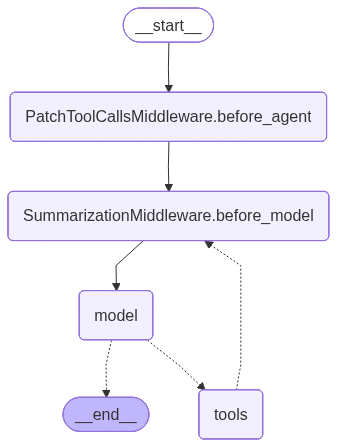

In [13]:
from deepagents import create_deep_agent
# updated since filming

# Create research sub-agent
research_sub_agent_2 = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=get_today_str()),
    "tools": [tavily_search, think_tool],
}


agent = create_deep_agent(  # updated 
    tools=sub_agent_tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent_2],
    model=model,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [14]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me an very brief overview of Model Context Protocol (MCP).",
            }
        ],
    }
)

format_messages(result["messages"])

/Users/geoffladwig/Documents/Github/TestV1/deep-agents-from-scratch/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: MCP - O...ser-interaction)\n\n \n', input_type=str])
  return self.__pydantic_serializer__.to_python(
/Users/geoffladwig/Documents/Github/TestV1/deep-agents-from-scratch/.venv/lib/python3.13/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: MCP - O...ser-interaction)\n\n \n', input_type=str])
  PydanticSerializationUnexpectedValue(Expected `general-fields` - serialized value may not be as expected [field_name='files', input_value='# Search Result: Anthrop...--------------------)\n',

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an very brief overview of Model Context Protocol (MCP).                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a brief overview of Model Context Protocol (MCP). Let me research this for you.               │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "in_progress"                                                                                   │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01HyCytbACzJJaJMruATSPJs                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'in_progress'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'pending'}]   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) and provide a comprehensive overview covering: what it  │
│ is, its purpose, key features, how it works, who developed it, and its main use cases. Focus on gathering       │
│ factual information from reliable sources about this protocol.",                                                │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01C5xzZTcfepshX7nyJNxMAW                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my research, here's a comprehensive overview of the Model Context Protocol (MCP):                      │
│                                                                                                                 │
│ ## What is the Model Context Protocol (MCP)?                                                                    │
│                                                                                                                 │
│ The Model Context Protocol (MCP) is an **open specification and standard** designed to connect large language   │
│ models (LLMs) to external tools, resources, and data sources. It serves as a standardized communication layer   │
│ that enables AI applications to seamlessly integrate with various external systems and APIs.                    │
│                                                                                                                 │
│ ## Purpose and Goals                                                                                            │
│                                                                                                                 │
│ MCP was created to address several key challenges in AI application development:                                │
│                                                                                                                 │
│ - **Standardize Integration**: Provides a unified way for AI applications to provide context to LLMs,           │
│ eliminating the need for custom coding for each API integration                                                 │
│ - **Reduce Complexity**: Simplifies the integration process between LLMs and external data sources              │
│ - **Improve Interoperability**: Enables different AI systems and tools to work together more effectively        │
│ - **Enable Real-time Access**: Supports real-time information retrieval and dynamic interactions                │
│                                                                                                                 │
│ ## Who Developed It?                                                                                            │
│                                                                                                                 │
│ MCP was developed by **Anthropic**, the company behind the Claude AI assistant. It represents Anthropic's       │
│ effort to create an open standard that benefits the entire AI ecosystem, not just their own products.           │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ MCP includes several core components and capabilities:                                                          │
│                                                                                                                 │
│ ### Core Primitives                                                                                             │
│ - **Tools**: Standardized way to expose and execute external functions and APIs                                 │
│ - **Resources**: Access to external data sources and content                                                    │
│ - **Prompts**: Structured prompt templates and management                                                       │
│ - **Sampling**: Controlled interaction patterns with LLMs                                                       │
│                                                                                                                 │
│ ### Technical Features                                 

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_012Qz1kpSUv5pvUbXMYRBXyj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'completed'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'in_progress'}] │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) - Brief Overview                                                                │
│                                                                                                                 │
│ **Model Context Protocol (MCP)** is an open standard developed by Anthropic that enables large language models  │
│ to connect seamlessly with external tools, data sources, and APIs.                                              │
│                                                                                                                 │
│ **Key Points:**                                                                                                 │
│ - **Purpose**: Standardizes how AI applications integrate with external systems, eliminating custom coding for  │
│ each integration                                                                                                │
│ - **Architecture**: Uses a client-server model with JSON-RPC communication                                      │
│ - **Core Features**: Provides tools, resources, prompts, and real-time notifications                            │
│ - **Benefits**: Simplifies AI app development, improves interoperability, and enables real-time data access     │
│ - **Use Cases**: Code repositories, databases, APIs, file systems, and communication platforms                  │
│                                                                                                                 │
│ **Bottom Line**: MCP is essentially a universal "connector" that makes it much easier for AI applications to    │
│ access and use external tools and data, creating a more integrated and capable AI ecosystem.                    │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) to gather key information",                             │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Provide a very brief overview based on research findings",                                    │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01Fie9RbMR24dSvbmSurm4wu                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) to gather key information', 'status':  │
│ 'completed'}, {'content': 'Provide a very brief overview based on research findings', 'status': 'completed'}]   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/1d626d81-a102-4588-a2fb-cab40a7271f1/r
<!-- https://smith.langchain.com/public/1ae2d7f6-f901-4ebd-b6c3-6657a55f88ae/r -->